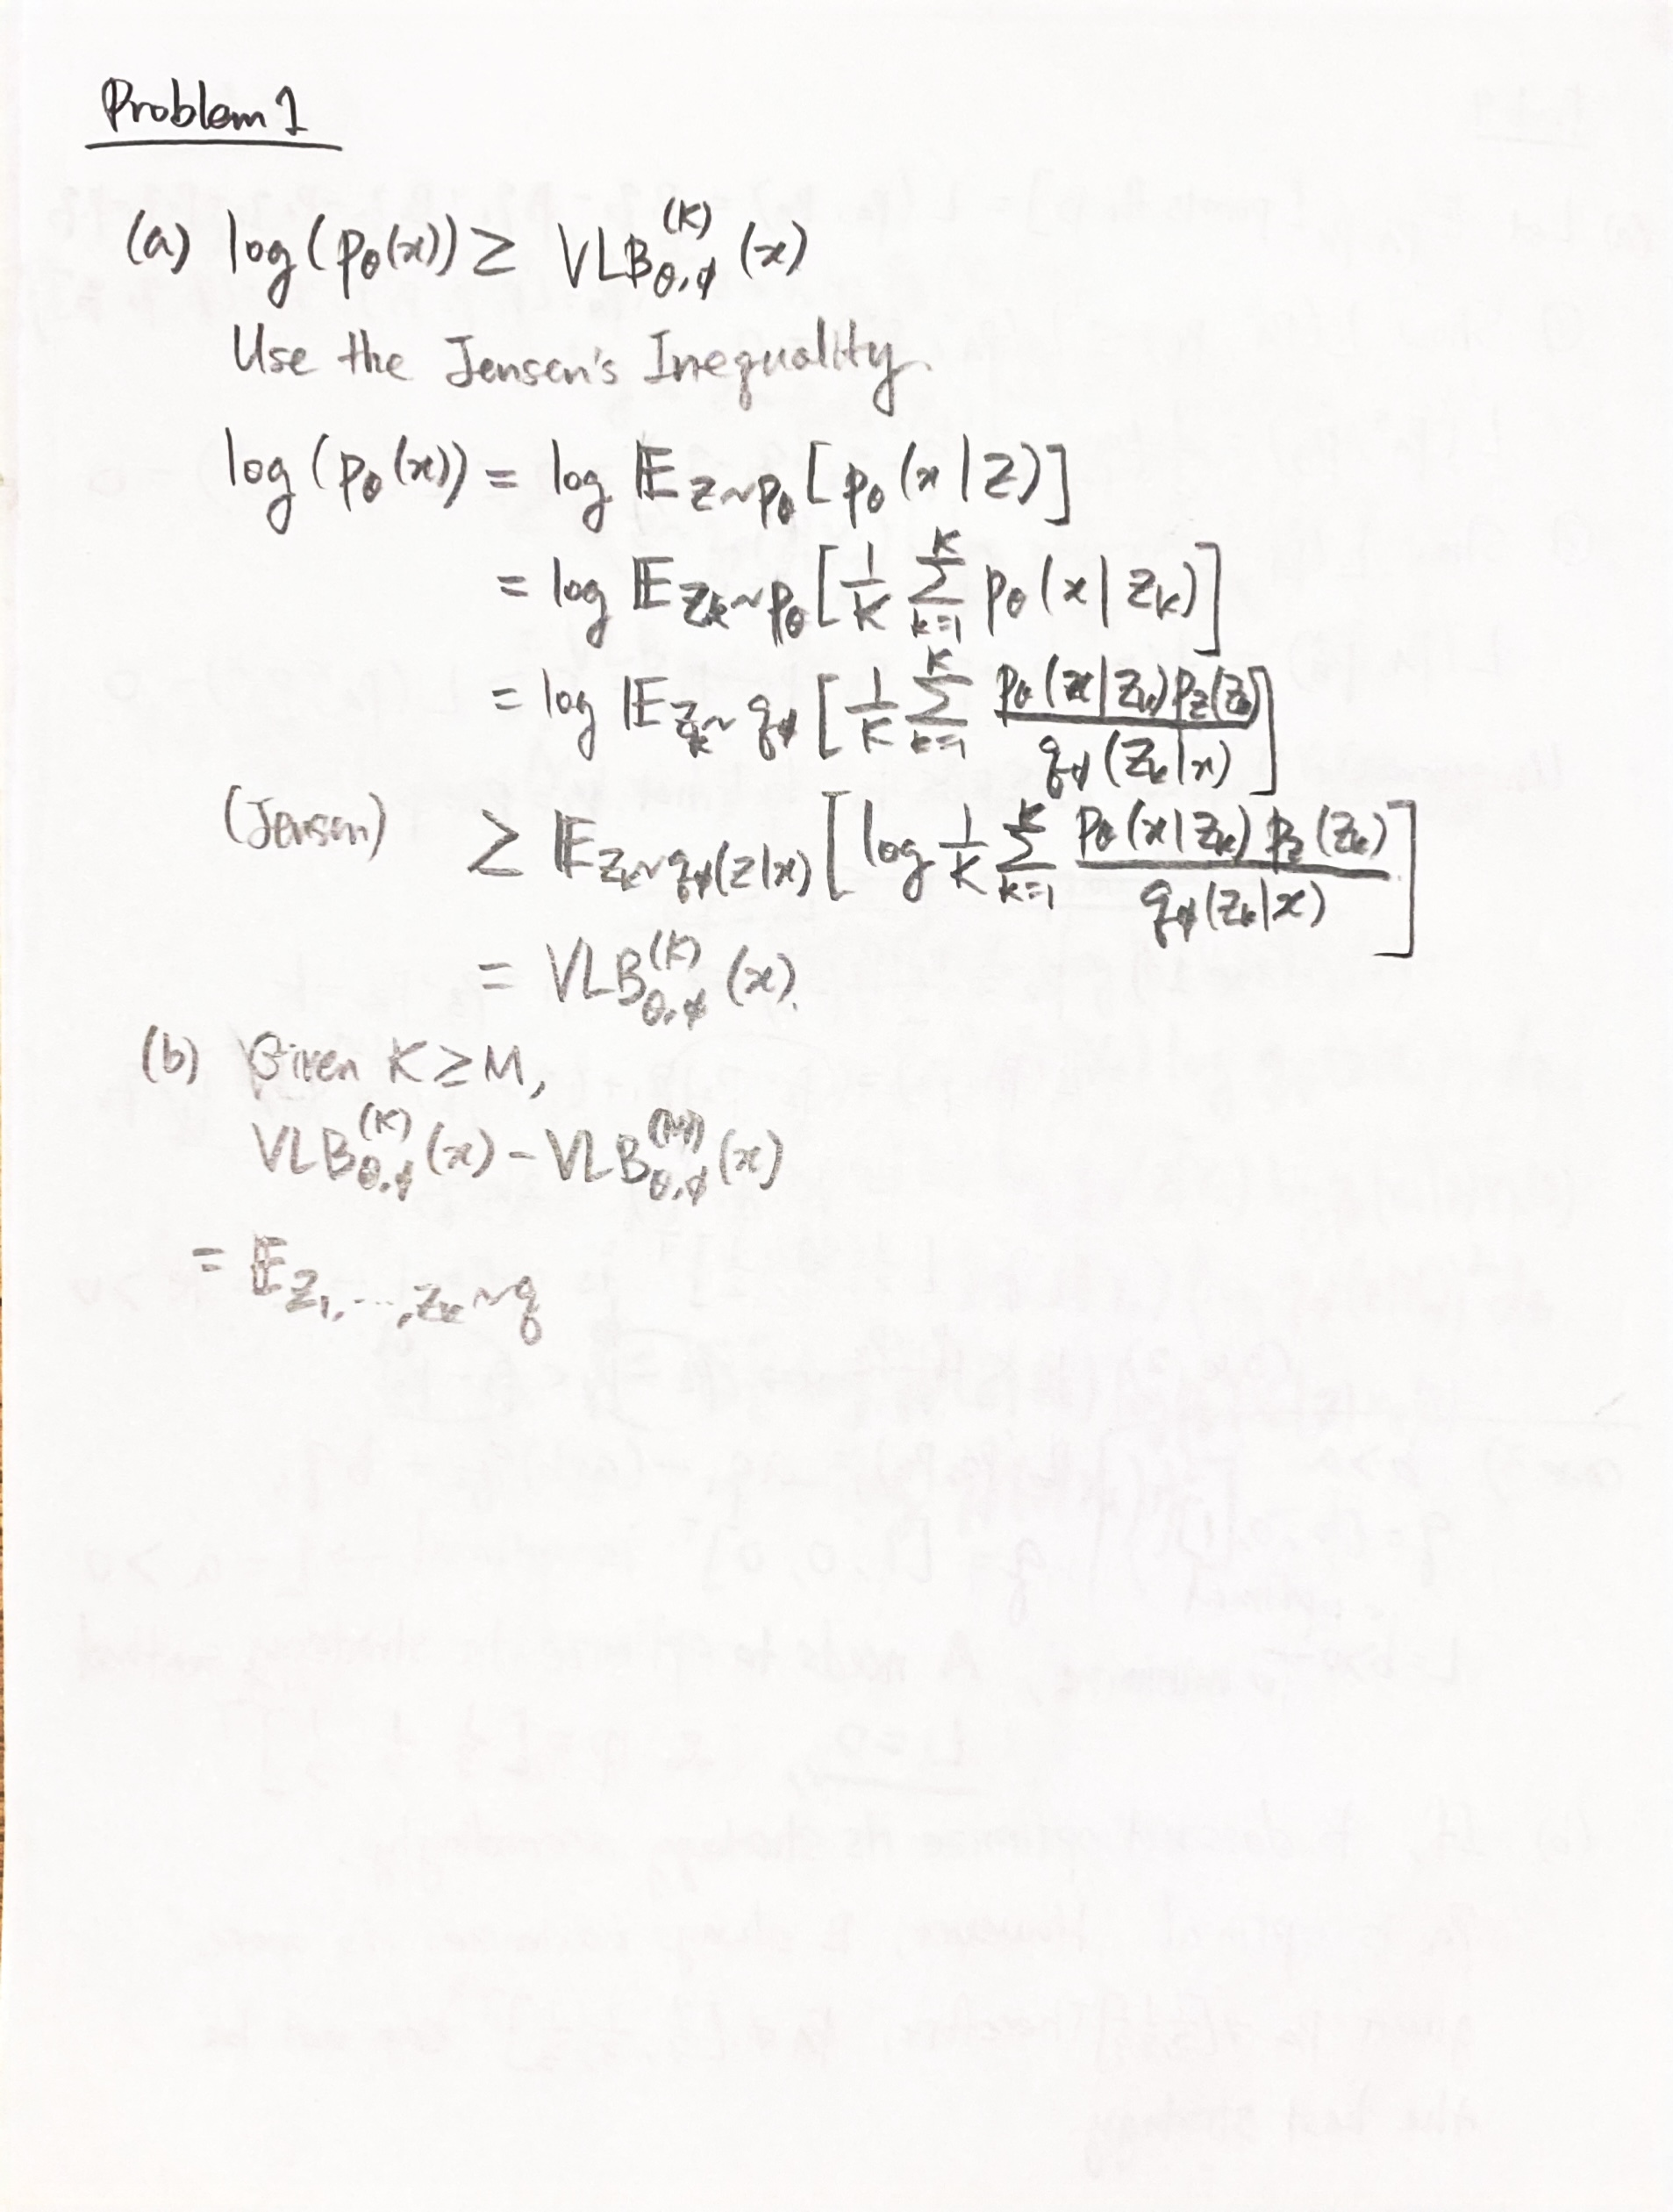

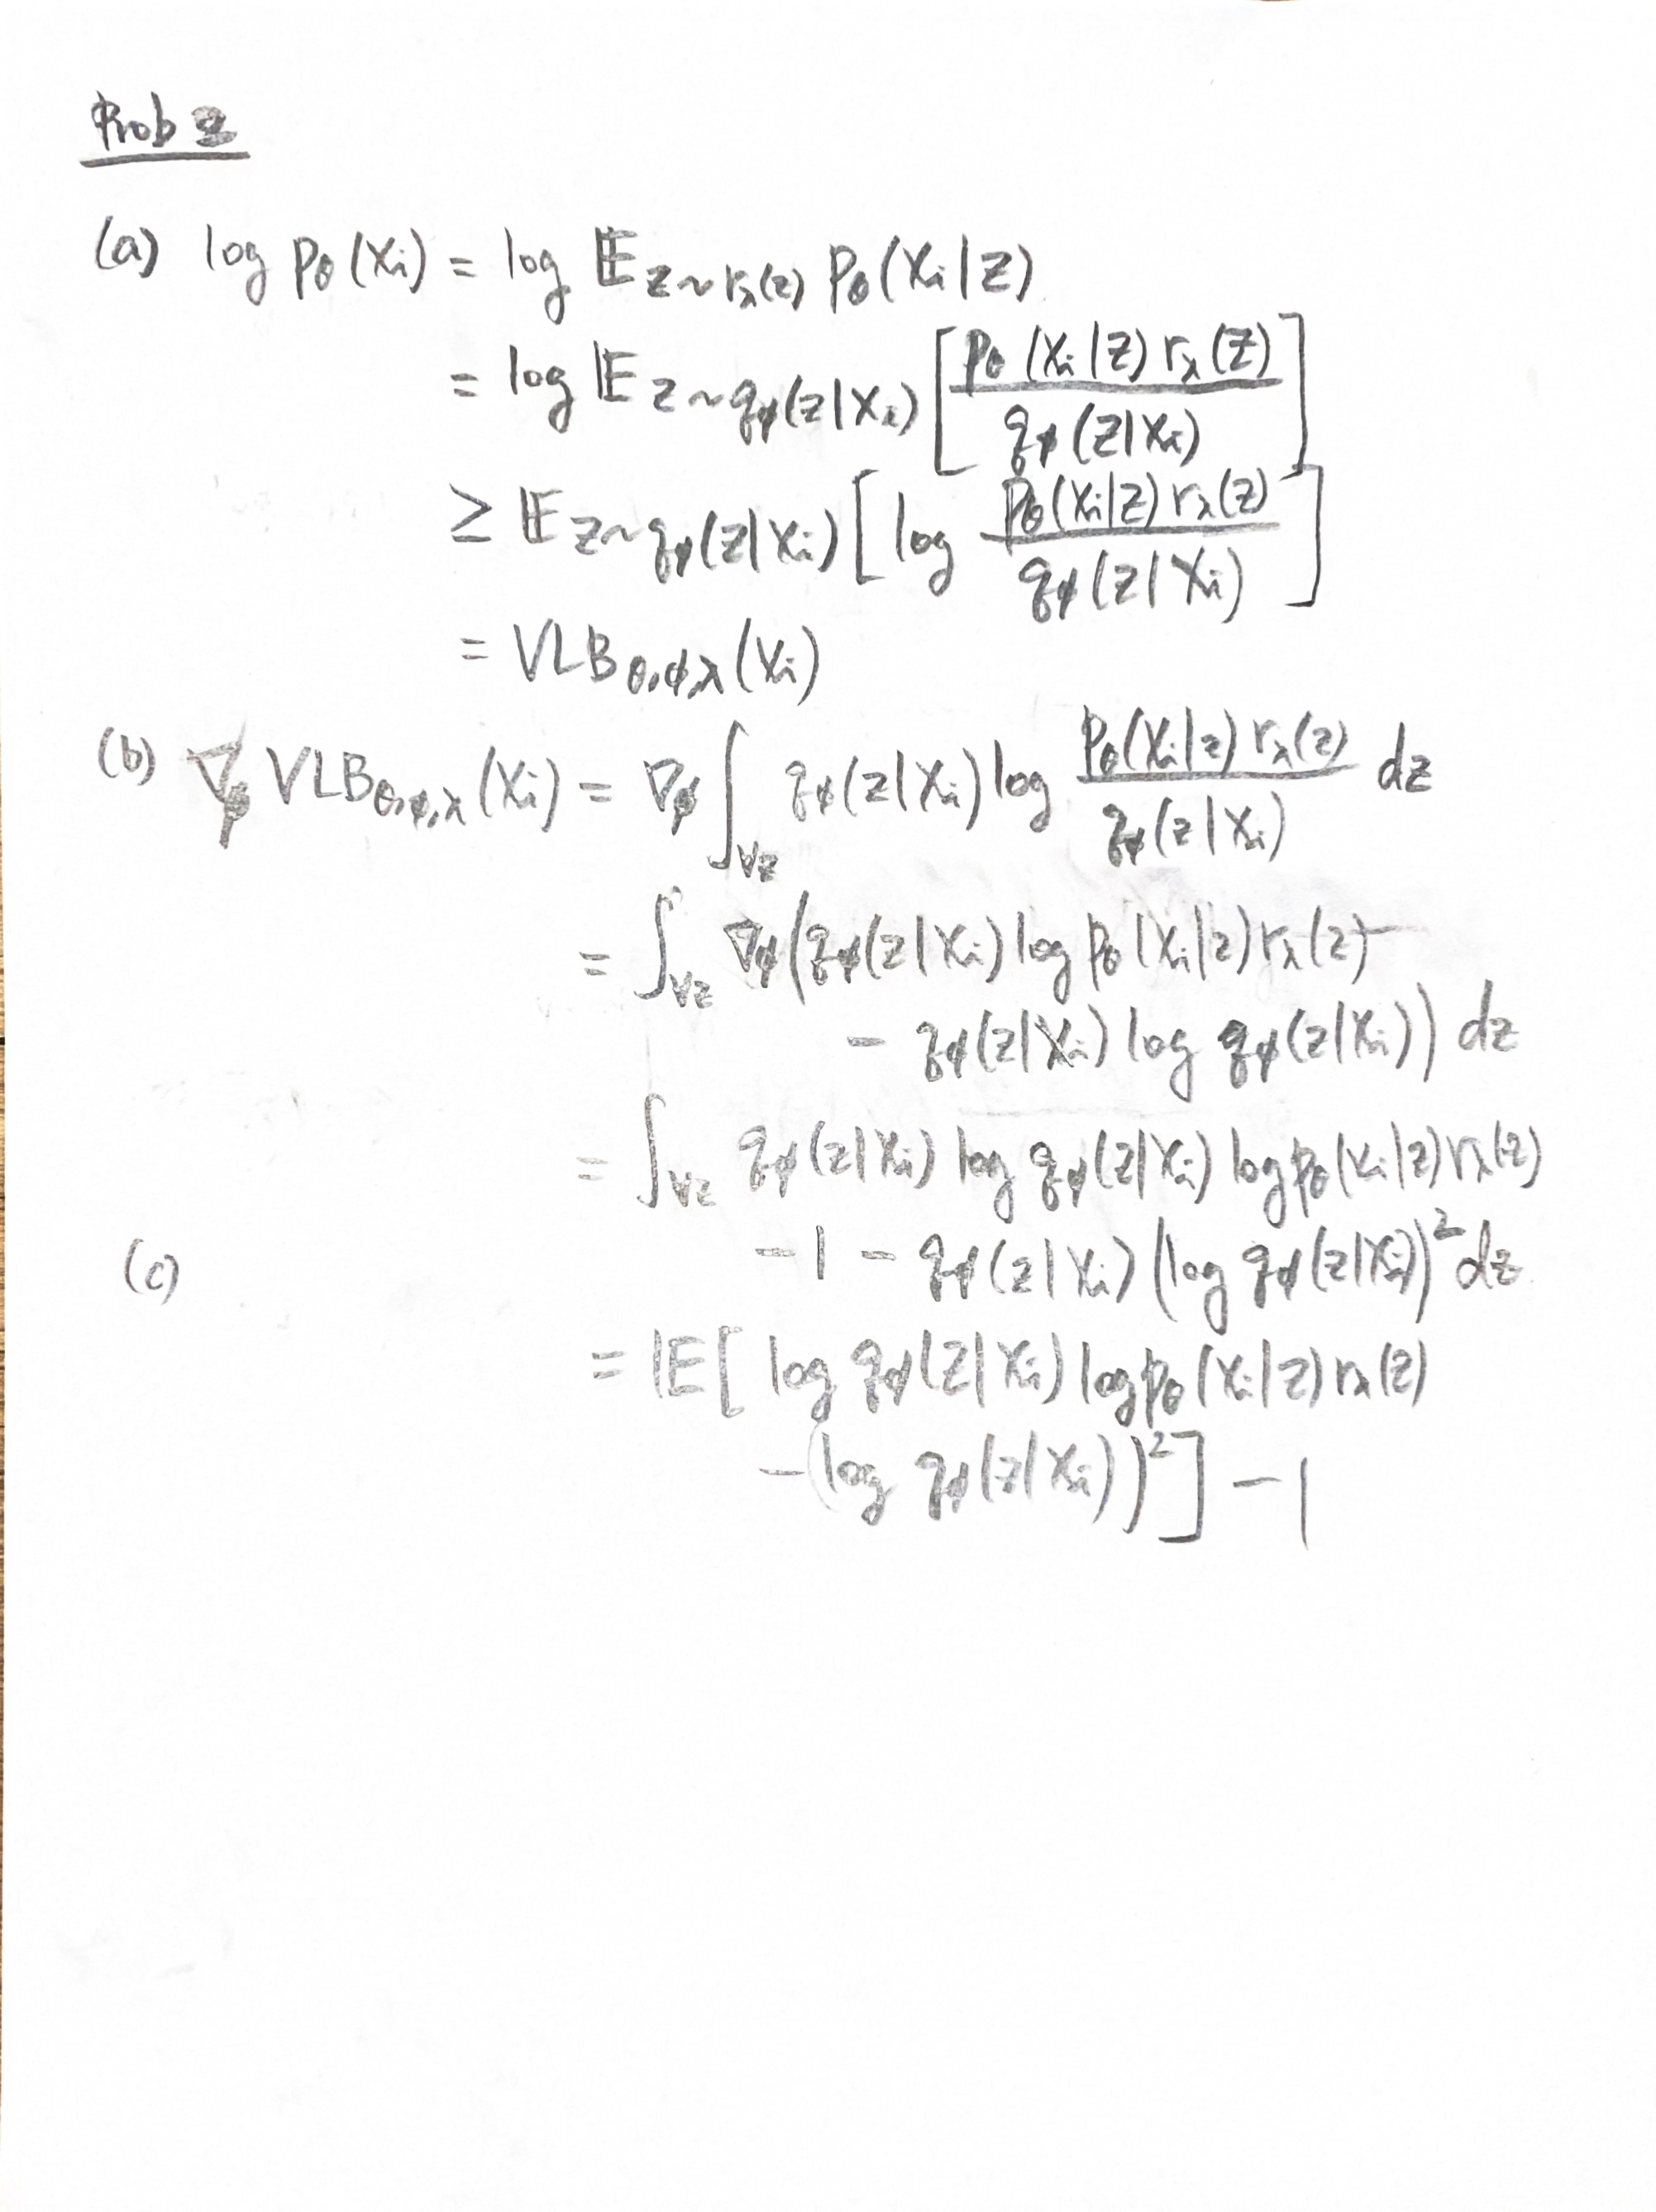

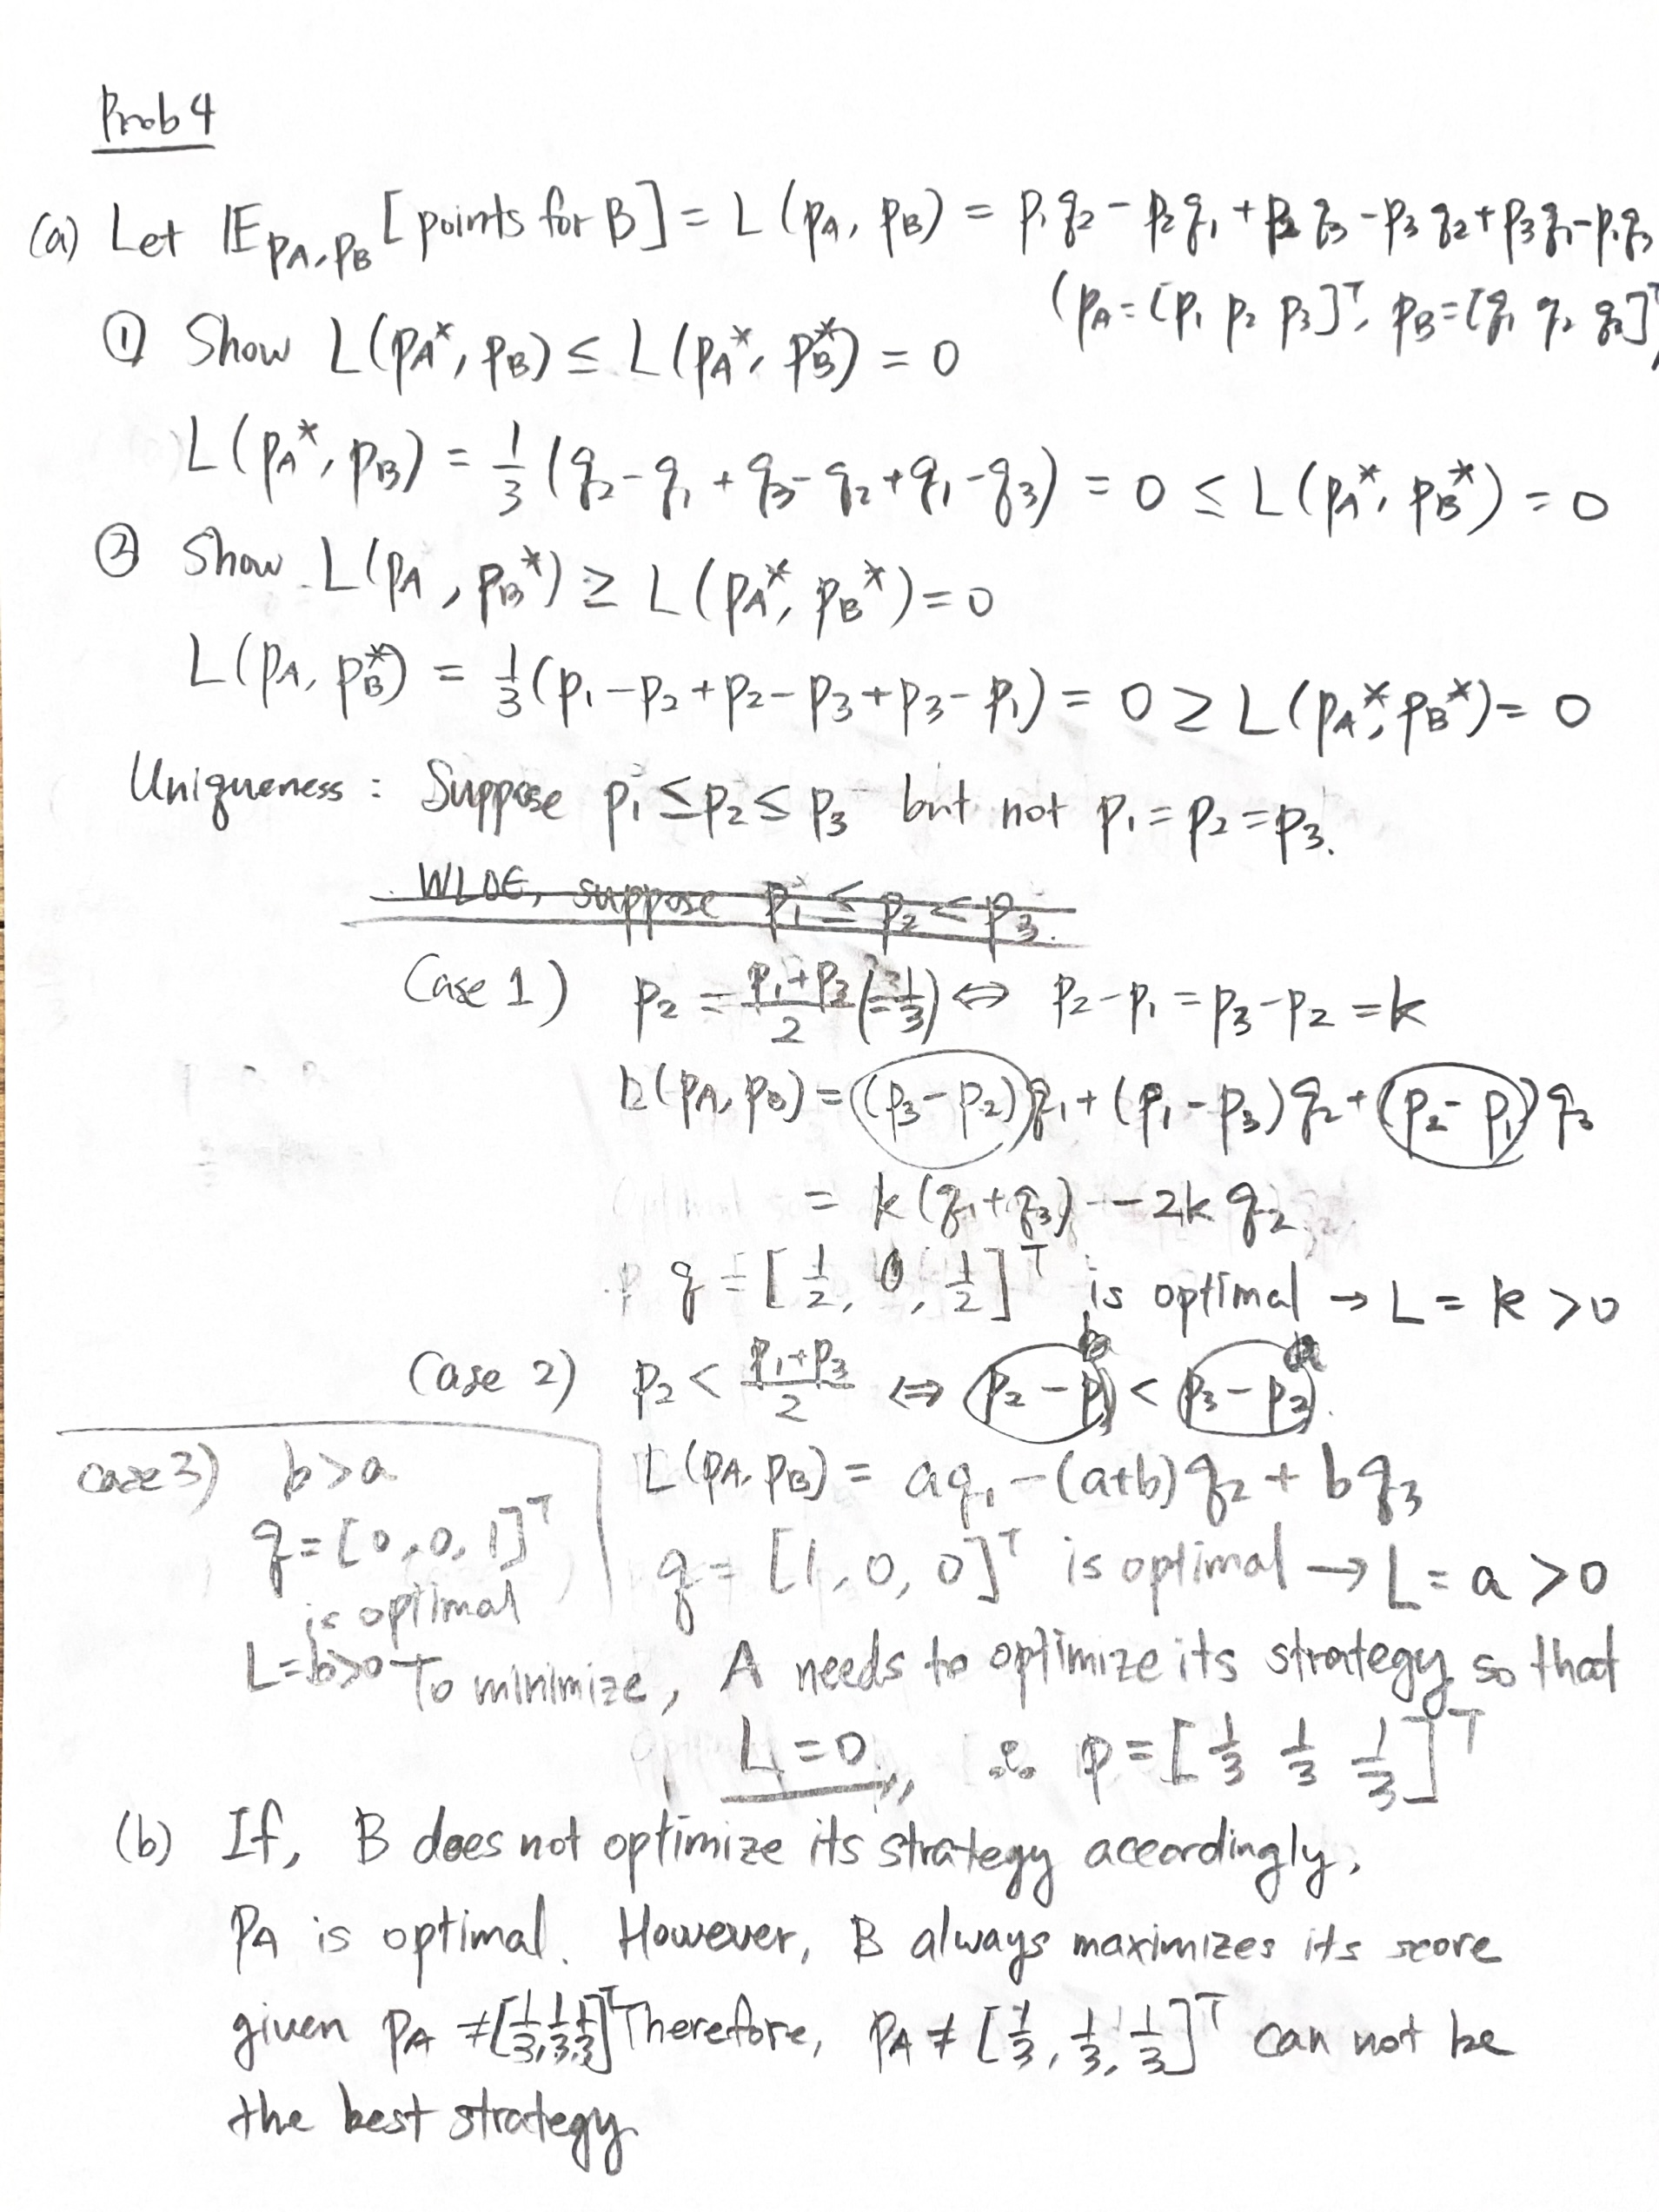

# Prob 3

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128

'''
Step 1:
'''
test_val_dataset = datasets.MNIST(root='./mnist_data/',
                train=False, 
                transform=transforms.ToTensor())

test_dataset, validation_dataset = \
    torch.utils.data.random_split(test_val_dataset, [5000, 5000])

# KMNIST dataset, only need test dataset
anomaly_dataset = datasets.KMNIST(root='./kmnist_data/',
                train=False, 
                transform=transforms.ToTensor(),
                download=True)

'''
Step 2: 
'''
# Define prior distribution
class Logistic(torch.distributions.Distribution):
  def __init__(self):
    super(Logistic, self).__init__()

  def log_prob(self, x):
    return -(F.softplus(x) + F.softplus(-x))

  def sample(self, size):
    z = torch.distributions.Uniform(0., 1.).sample(size).to(device)
    return torch.log(z) - torch.log(1. - z)

# Implement coupling layer
class Coupling(nn.Module):
  def __init__(self, in_out_dim, mid_dim, hidden, mask_config):
    super(Coupling, self).__init__()
    self.mask_config = mask_config
    
    self.in_block = \
        nn.Sequential(nn.Linear(in_out_dim//2, mid_dim), nn.ReLU())
    self.mid_block = nn.ModuleList(
        [nn.Sequential(nn.Linear(mid_dim, mid_dim), nn.ReLU()) 
          for _ in range(hidden - 1)])
    self.out_block = nn.Linear(mid_dim, in_out_dim//2)

  def forward(self, x, reverse=False):
    [B, W] = list(x.size())
    x = x.reshape((B, W//2, 2))
    if self.mask_config:
      on, off = x[:, :, 0], x[:, :, 1]
    else:
      off, on = x[:, :, 0], x[:, :, 1]

    off_ = self.in_block(off)
    for i in range(len(self.mid_block)):
      off_ = self.mid_block[i](off_)
    shift = self.out_block(off_)
    
    if reverse:
      on = on - shift
    else:
      on = on + shift

    if self.mask_config:
      x = torch.stack((on, off), dim=2)
    else:
      x = torch.stack((off, on), dim=2)
    return x.reshape((B, W))

class Scaling(nn.Module):
  def __init__(self, dim):
    super(Scaling, self).__init__()
    self.scale = nn.Parameter(torch.zeros((1, dim)))

  def forward(self, x, reverse=False):
    log_det_J = torch.sum(self.scale)
    if reverse:
      x = x * torch.exp(-self.scale)
    else:
      x = x * torch.exp(self.scale)
    return x, log_det_J

class NICE(nn.Module):
  def __init__(self,in_out_dim, mid_dim, hidden,
        mask_config=1.0, coupling=4):
    super(NICE, self).__init__()
    self.prior = Logistic()
    self.in_out_dim = in_out_dim

    self.coupling = nn.ModuleList([
      Coupling(in_out_dim=in_out_dim, 
           mid_dim=mid_dim, 
           hidden=hidden, 
           mask_config=(mask_config+i)%2) \
      for i in range(coupling)])
    
    self.scaling = Scaling(in_out_dim)

  def g(self, z):
    x, _ = self.scaling(z, reverse=True)
    for i in reversed(range(len(self.coupling))):
      x = self.coupling[i](x, reverse=True)
    return x

  def f(self, x):
    for i in range(len(self.coupling)):
      x = self.coupling[i](x)
    z, log_det_J = self.scaling(x)
    return z, log_det_J

  def log_prob(self, x):
    z, log_det_J = self.f(x)
    log_ll = torch.sum(self.prior.log_prob(z), dim=1)
    return log_ll + log_det_J

  def sample(self, size):
    z = self.prior.sample((size, self.in_out_dim)).to(device)
    return self.g(z)

  def forward(self, x):
    return self.log_prob(x)
  
'''
Step 3: Load the pretrained model
'''
nice = NICE(in_out_dim=784, mid_dim=1000, hidden=5).to(device)
nice.load_state_dict(torch.load('nice.pt', map_location=device))
print("nice loading completed")


nice loading completed


In [9]:
'''
Step 4: Calculate standard deviation by using validation set
'''
validation_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset, batch_size=1)

sum_log_prob = 0
sum_log_prob_squared = 0
n_val = len(validation_loader)

for images, _ in validation_loader:
    with torch.no_grad():
        images = images.to(device)
        log_prob = nice(images.reshape(1, 784))
        sum_log_prob += log_prob
        sum_log_prob_squared += log_prob ** 2

mean = sum_log_prob / n_val
std = torch.sqrt(sum_log_prob_squared / n_val - mean ** 2)


threshold = mean - 3 * std
print("threshold: ", threshold)

'''
Step 5: Anomaly detection (mnist)
'''
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=1)

n_test = len(test_loader)
count_test = 0

for images, _ in test_loader:
    with torch.no_grad():
        images = images.to(device)
        log_prob = nice(images.reshape((1, 784)))
        if log_prob > threshold:
            count_test += 1
print("Type I error rate:", count_test/n_test)

'''
Step 6: Anomaly detection (kmnist)
'''
anomaly_loader = torch.utils.data.DataLoader(
    dataset=anomaly_dataset, batch_size=1)

n_anomaly = len(anomaly_loader)
count_anomaly = 0

for images, _ in anomaly_loader:
    with torch.no_grad():
        images = images.to(device)
        log_prob = nice(images.reshape((1, 784)))
        if log_prob > threshold:
            count_anomaly += 1
print("Type II error rate:", 1 - count_anomaly/n_anomaly)

threshold:  tensor([-642.8035])
Type I error rate: 0.9836
Type II error rate: 0.9984
